In [1]:
import pandas as pd
from data.Functions import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Loading the dataset

In [2]:
data = pd.read_csv('data/ml_gw_car_insurance.csv')
data.columns

Index(['Unnamed: 0', 'policy_id', 'policy_tenure', 'age_of_car',
       'age_of_policyholder', 'area_cluster', 'population_density', 'make',
       'segment', 'model', 'fuel_type', 'max_torque', 'max_power',
       'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms',
       'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
       'displacement', 'cylinder', 'transmission_type', 'gear_box',
       'steering_type', 'turning_radius', 'length', 'width', 'height',
       'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim'],
      dtype='object')

In [3]:
dataset = data_processing(data)

# Functions

One function will directly split the dataset into train and test and output the model results with the defined parameters for XGBoost.
The results will be a prediciton from 0 to 1.

The second function elaborates a table with different methods to choose the optimal decision threshold (to distinguish positive and negative outcomes)
- Default: Use the default 0,5 threshold;
- Precision-Recall trade-off: Optimize PR trade-off (using F1 Score);
- Balanced Accuracy: Maximize Sensitivity and Specificity average;
- Cohen's Kappa: Maximize a statistic that measures inter-annotator agreement. (Similarity between predicitons and real values).

In [4]:
#Functions

import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score


def xgb_classifier(features, target):
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test  


def evaluate_thresholds(y_pred_train, y_train, y_pred_test, y_test, metrics = "test"):

    if metrics == "test":
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_test >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_test, default_y_pred_binary)
        default_recall = recall_score(y_test, default_y_pred_binary)
        default_precision = precision_score(y_test, default_y_pred_binary)
        default_roc_auc = roc_auc_score(y_test, default_y_pred_binary)
        default_f1 = f1_score(y_test, default_y_pred_binary, pos_label=1)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_test >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
        pr_recall = recall_score(y_test, pr_y_pred_binary)
        pr_precision = precision_score(y_test, pr_y_pred_binary)
        pr_roc_auc = roc_auc_score(y_test, pr_y_pred_binary)
        pr_f1 = f1_score(y_test, pr_y_pred_binary, pos_label=1)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_test >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
        ba_recall = recall_score(y_test, ba_y_pred_binary)
        ba_precision = precision_score(y_test, ba_y_pred_binary)
        ba_roc_auc = roc_auc_score(y_test, ba_y_pred_binary)
        ba_f1 = f1_score(y_test, ba_y_pred_binary, pos_label=1)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
        kappa_recall = recall_score(y_test, kappa_y_pred_binary)
        kappa_precision = precision_score(y_test, kappa_y_pred_binary)
        kappa_roc_auc = roc_auc_score(y_test, kappa_y_pred_binary)
        kappa_f1 = f1_score(y_test, kappa_y_pred_binary, pos_label=1)


    else:
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_train >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_train, default_y_pred_binary)
        default_recall = recall_score(y_train, default_y_pred_binary)
        default_precision = precision_score(y_train, default_y_pred_binary)
        default_roc_auc = roc_auc_score(y_train, default_y_pred_binary)
        default_f1 = f1_score(y_train, default_y_pred_binary, pos_label=1)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_train >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_train, pr_y_pred_binary)
        pr_recall = recall_score(y_train, pr_y_pred_binary)
        pr_precision = precision_score(y_train, pr_y_pred_binary)
        pr_roc_auc = roc_auc_score(y_train, pr_y_pred_binary)
        pr_f1 = f1_score(y_train, pr_y_pred_binary, pos_label=1)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_train >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_train, ba_y_pred_binary)
        ba_recall = recall_score(y_train, ba_y_pred_binary)
        ba_precision = precision_score(y_train, ba_y_pred_binary)
        ba_roc_auc = roc_auc_score(y_train, ba_y_pred_binary)
        ba_f1 = f1_score(y_train, ba_y_pred_binary, pos_label=1)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_train >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_train, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_train, kappa_y_pred_binary)
        kappa_recall = recall_score(y_train, kappa_y_pred_binary)
        kappa_precision = precision_score(y_train, kappa_y_pred_binary)
        kappa_roc_auc = roc_auc_score(y_train, kappa_y_pred_binary)
        kappa_f1 = f1_score(y_train, kappa_y_pred_binary, pos_label=1)

    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa"],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2)], 
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2)], 
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2)],
        'f1_score': [round(default_f1,2), round(pr_f1, 2), round(ba_f1, 2), round(kappa_f1, 2)],
        'roc_auc': [round(default_roc_auc,2), round(pr_roc_auc, 2), round(ba_roc_auc, 2), round(kappa_roc_auc, 2)],

        #'Precision@K': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df



# XGBoost Model

Using previous functions to elaborate the model.

Feature importance graphs shows the features selected by the model and their impact. The features are chosen based on the train set only.


In [5]:
X = dataset.drop(['is_claim'],axis=1) # Features
y = dataset.is_claim # Target variable
features=X.columns
y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

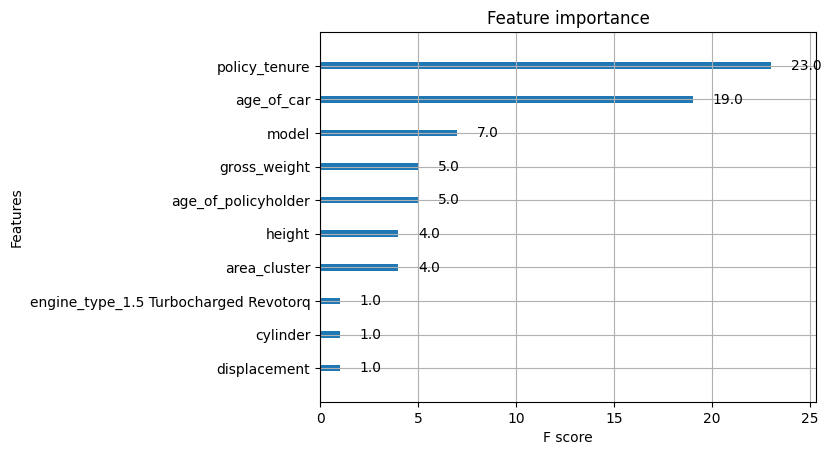

In [6]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [7]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Analysis,Threshold,Accuracy,Recall,Precision,f1_score,roc_auc
0,Default,0.50,0.94,0.00,0.00,0.00,0.50
1,Precision-Recall trade-off,0.10,0.77,0.40,0.12,0.18,0.60
2,Balanced Accuracy,0.09,0.63,0.62,0.10,0.17,0.62
3,Cohen's Kappa,0.10,0.76,0.42,0.12,0.18,0.60


In [8]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'precision_at_k' is not defined

Results aren't very good when calculated on the train set and deteriorate event more when calculated on the test set. However, based on the business problem, metrics that are relevant for the analysis and representation of risk that the insurance company could take (Recall and Roc-Auc), the best model would be the one built using balanced accuracy, wich has the highest recall and the highest roc-auc. Still the

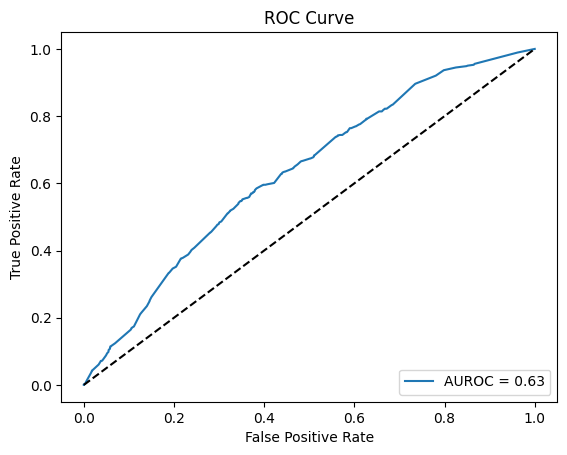

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_test)

# Calculate the AUROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

We can see in the graph that the model is a bad fitting for the data.

# Fine Tune

Hyperparameters can be choosed using Gridsearch.
This process took long and results using the new parametes didn't showed any relevant improvement.


In [14]:
gsc = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "learning_rate": (0.05, 0.10, 0.15),
        "max_depth": [3, 4, 5, 6, 8],
        "min_child_weight": [1, 3, 5, 7],
        "gamma": [0.0, 0.1, 0.2],
        "colsample_bytree": [0.3, 0.4]
    },
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

KeyboardInterrupt: 

In [44]:
best_params

{'colsample_bytree': 0.3,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 7}

From grid search
{'colsample_bytree': 0.3,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 7}

# Conclusion

XGboost model is fitting poorly the data and predictions are just slightly better than random guessing. One way of improving the model could be adding new features, wich is not easy in our context. Therefore is better to use other models.
